# Customer Churn Analysis

### Primary Goals - 
* Find users that are going to churn in future?
* What factors drive users to churn?

In [139]:
#importing libraries
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm #logistic regression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV #hyperparamter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from xgboost import XGBClassifier
import warnings; warnings.simplefilter('ignore')

In [2]:
#meta-data
v_dict = {"city": "city this user signed up in","phone": "primary device for this user","signup_date": "date of account registration; in the form `YYYYMMDD`",
"last_trip_date": "the last time this user completed a trip; in the form `YYYYMMDD`","avg_dist": "the average distance (in miles) per trip taken in the first 30 days after signup",
"avg_rating_by_driver": "the rider’s average rating over all of their trips","avg_rating_of_driver": "the rider’s average rating of their drivers over all of their trips", 
"surge_pct": "the percent of trips taken with surge multiplier > 1","avg_surge": "The average surge multiplier over all of this user’s trips", 
"trips_in_first_30_days": "the number of trips this user took in the first 30 days after signing up","luxury_car_user": "TRUE if the user took a luxury car in their first 30 days; FALSE otherwise",
"weekday_pct": "the percent of the user’s trips occurring during a weekday"}
#meta data information
pd.set_option('display.max_colwidth',-1)
pd.DataFrame(list(v_dict.items()),columns = ["variable","description"])

,variable,description
0,city,city this user signed up in
1,phone,primary device for this user
2,signup_date,date of account registration; in the form `YYYYMMDD`
3,last_trip_date,the last time this user completed a trip; in the form `YYYYMMDD`
4,avg_dist,the average distance (in miles) per trip taken in the first 30 days after signup
5,avg_rating_by_driver,the rider’s average rating over all of their trips
6,avg_rating_of_driver,the rider’s average rating of their drivers over all of their trips
7,surge_pct,the percent of trips taken with surge multiplier > 1
8,avg_surge,The average surge multiplier over all of this user’s trips
9,trips_in_first_30_days,the number of trips this user took in the first 30 days after signing up


## DATA

In [3]:
#loading data
data = pd.read_csv("C:/Users/pares/OneDrive/Documents/assessments/churn prediction/churn.csv")
data.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
avg_dist,3.67,8.26,0.77,2.36,3.13,10.56,3.95,2.04,4.36,2.37
avg_rating_by_driver,5,5,5,4.9,4.9,5,4,5,5,5
avg_rating_of_driver,4.7,5,4.3,4.6,4.4,3.5,NaN,5,4.5,NaN
avg_surge,1.1,1,1,1.14,1.19,1,1,1,1,1
city,King's Landing,Astapor,Astapor,King's Landing,Winterfell,Winterfell,Astapor,Winterfell,Winterfell,Winterfell
last_trip_date,2014-06-17,2014-05-05,2014-01-07,2014-06-29,2014-03-15,2014-06-06,2014-01-25,2014-01-29,2014-02-01,2014-01-05
phone,iPhone,Android,iPhone,iPhone,Android,iPhone,Android,iPhone,Android,Android
signup_date,2014-01-25,2014-01-29,2014-01-06,2014-01-10,2014-01-27,2014-01-09,2014-01-24,2014-01-28,2014-01-21,2014-01-03
surge_pct,15.4,0,0,20,11.8,0,0,0,0,0
trips_in_first_30_days,4,0,3,9,14,2,1,2,2,1


In [4]:
#Available Information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Basic information about data
- Every row represents a separate customer. The data has a total of 50,000 customers.
- Data types for columns last_trip_date and signup_date are wrong. Need to correct the type
- In total, we have 7 numerical variables; 2 categorical; 1 boolean and 2 date columns. We need to create a target variable.
- 3 variables have MISSING VALUES - avg_rating_by_driver; avg_rating_of_driver and phone.

In [5]:
#Lets first convert columns to their appropriate data types
data.signup_date = data.signup_date.astype('datetime64')
data.last_trip_date = data.last_trip_date.astype("datetime64")

#### We need a response variable -- 

In [6]:
print("------Last trip date decription-------")
print()
print(data.last_trip_date.describe())
print()
print("------Sign up date decription-------")
print()
print(data.signup_date.describe())

------Last trip date decription-------

count     50000              
unique    182                
top       2014-06-29 00:00:00
freq      2036               
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

------Sign up date decription-------

count     50000              
unique    31                 
top       2014-01-18 00:00:00
freq      2948               
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object


- So looks like, users signed up in January and have used the app till 1st of July, 2014.
- To create the target variable, we need to determine which users are active, and who have stopped using the application. Lets see the breakdown by each month

In [7]:
#Lets see the breakdown by months
last_trip_bd = data.groupby(data['last_trip_date'].dt.strftime('%B')).last_trip_date.count()
cats = ['January', 'February', 'March', 'April','May','June', 'July', 'August','September', 'October', 'November', 'December']
last_trip_bd.index = pd.CategoricalIndex(last_trip_bd.index, categories=cats, ordered=True)
last_trip_bd = last_trip_bd.sort_index()
last_trip_bd

last_trip_date
January     10147
February    4308 
March       4568 
April       4588 
May         7585 
June        18256
July        548  
Name: last_trip_date, dtype: int64

- Clearly, users who have used the app in July and June, are customers who are still loyal to the company. However, customers who last used the app before June (in May or before) have gone by without using the app for a considerable time. Lets mark them as inactive (or users who have churned).

In [8]:
#Any user whose last trip with the company was before 1st June, 2014 is considered to be "churned". 
data["churned"] = 1
data["churned"][data.last_trip_date >= "2014-06-01"] = 0
data.churned = data.churned.astype("category")

In [9]:
#sanity check
data.head().transpose()

,0,1,2,3,4
avg_dist,3.67,8.26,0.77,2.36,3.13
avg_rating_by_driver,5,5,5,4.9,4.9
avg_rating_of_driver,4.7,5,4.3,4.6,4.4
avg_surge,1.1,1,1,1.14,1.19
city,King's Landing,Astapor,Astapor,King's Landing,Winterfell
last_trip_date,2014-06-17 00:00:00,2014-05-05 00:00:00,2014-01-07 00:00:00,2014-06-29 00:00:00,2014-03-15 00:00:00
phone,iPhone,Android,iPhone,iPhone,Android
signup_date,2014-01-25 00:00:00,2014-01-29 00:00:00,2014-01-06 00:00:00,2014-01-10 00:00:00,2014-01-27 00:00:00
surge_pct,15.4,0,0,20,11.8
trips_in_first_30_days,4,0,3,9,14


#### Duplicated values

In [10]:
data[data.duplicated()].shape

(8, 13)

Although, we dont have a unique customer ID for each customer, having all values similar looks highly unlikely for 2 customers. There are 8 such rows in the data (customer having the same city, same phone, same signup_date, same last_trip_date looks highly unlikely)

In [11]:
clean_data = data.copy()
clean_data.drop_duplicates(inplace = True)

In [12]:
#We have a total of 49,992 customers
clean_data.shape

(49992, 13)

In [13]:
#Since, we have used last_trip_date to create our target variable, we can drop the variable from further analysis
clean_data.drop(["last_trip_date"],axis = 1,inplace = True)

In [14]:
#Before moving further, lets separate our variables based on their types
#Separating columns by data types
def separate(df):
    separated_cols = {
        "categorical" : list(df.select_dtypes(include = ["bool","object","category"]).columns),
        "continuous" : list(df.select_dtypes(include = ["int64","float64"]).columns),
        "date" : list(df.select_dtypes(include = ["datetime"]).columns)
    }
    return separated_cols

separate(clean_data)

{'categorical': ['city', 'phone', 'luxury_car_user', 'churned'],
 'continuous': ['avg_dist',
  'avg_rating_by_driver',
  'avg_rating_of_driver',
  'avg_surge',
  'surge_pct',
  'trips_in_first_30_days',
  'weekday_pct'],
 'date': ['signup_date']}

## Missing Values?

In [15]:
clean_data.isnull().sum()

avg_dist                  0   
avg_rating_by_driver      201 
avg_rating_of_driver      8119
avg_surge                 0   
city                      0   
phone                     396 
signup_date               0   
surge_pct                 0   
trips_in_first_30_days    0   
luxury_car_user           0   
weekday_pct               0   
churned                   0   
dtype: int64

- Why does column "phone" have missing values? (The customer needs a phone to use the app - Could be an different OS- Need further look)
- Having missing values for ratings seem intuitive. Not all customers provide a rating to the drivers. Similar for Drivers.

## Lets analyze each variable individually - UNIVARIATE ANALYSIS

- TARGET Variable - CHURN

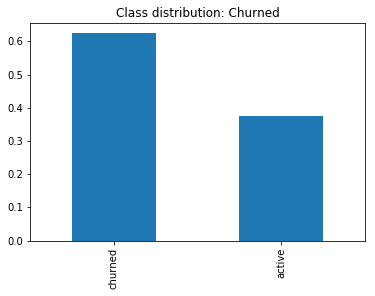

In [16]:
#Churn distribution
clean_data.churned.value_counts(normalize = True).plot(kind = "bar",title = "Class distribution: Churned")
plt.xticks(np.arange(2),labels = ["churned","active"])
plt.show()

- the class distribution is almost 60/40. This is not ideal, but might work. We'll go ahead with the data as it is. Based on the results, we'll either up-sample/down-sample/use the SMOTE technique to balance the distribution.

#### Categorical variables

In [17]:
cat_cols = separate(clean_data)["categorical"]
cat_cols.remove("churned")
cat_cols

['city', 'phone', 'luxury_car_user']

,city,phone,luxury_car_user
count,49992,49596,49992
unique,3,2,2
top,Winterfell,iPhone,False
freq,23331,34578,31141


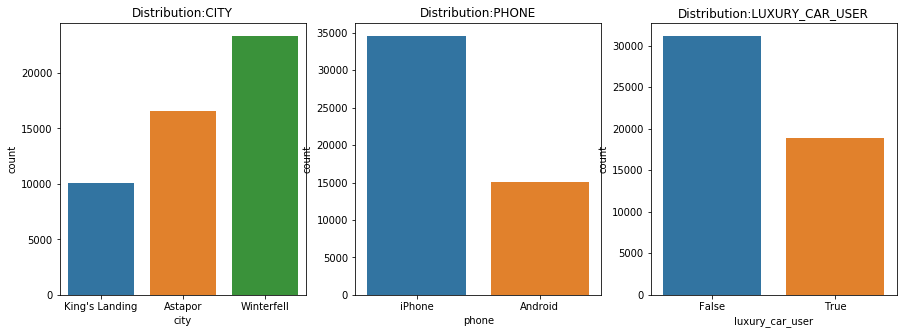

In [18]:
fig, ax= plt.subplots(1,3, figsize = (15,5))
for i, col in enumerate(cat_cols):
    sns.countplot(x = col,data = clean_data, ax = ax[i])
    ax[i].set_title("Distribution:"+ col.upper())
clean_data[cat_cols].describe()

- Majority population comes from Winterfell, have an iphone and haven't used a luxury car in their first 30 days

#### Numerical Variables

In [19]:
cont_cols = separate(clean_data)["continuous"]
clean_data[cont_cols].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,49992.00000,49791.000000,41873.000000,49992.000000,49992.000000,49992.000000,49992.000000
mean,5.79726,4.778123,4.601512,1.074776,8.850952,2.278405,60.929833
std,5.70761,0.446679,0.617360,0.222352,19.960094,3.792953,37.078229
min,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.42000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.88000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.94000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.96000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


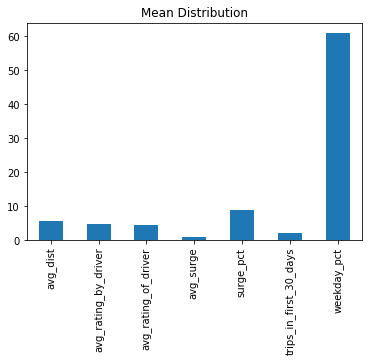

In [20]:
clean_data[cont_cols].mean().plot(kind = "bar")
plt.title("Mean Distribution")
plt.show()

- We need to scale the numerical features, owing to such varied degree of means of variables

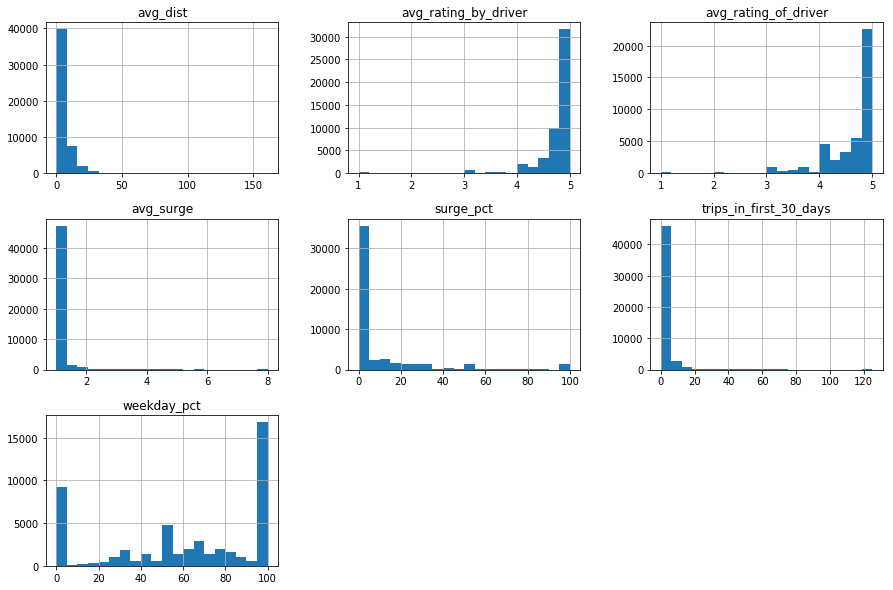

In [21]:
clean_data[cont_cols].hist(figsize = (15,10),bins = 20)
plt.show()

### Insights
- Almost all varibales are skewed. We need to transform them.
- Customer/ Driver ratings can give us an insight into their behaviour and personality. We can create new features using the variable.
- Avg_surge has most obs. at 1 and surge_pct at 0. There could be some correlation here. Need further analysis.
- All outlier points need further investigation.

## OUTLIERS

- Lets investigate outliers for every variable
#### Avg_dist

In [22]:
clean_data[clean_data["avg_dist"] > 50].shape

(41, 12)

In [23]:
clean_data[clean_data["avg_dist"] > 50].head(5)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churned
534,129.89,5.0,NaN,1.0,King's Landing,NaN,2014-01-04,0.0,0,False,0.0,1
799,60.58,5.0,5.0,1.0,Astapor,Android,2014-01-28,0.0,0,False,100.0,1
1302,79.69,5.0,5.0,1.0,Winterfell,iPhone,2014-01-30,0.0,1,False,100.0,1
1482,52.15,4.0,NaN,1.0,King's Landing,Android,2014-01-08,0.0,1,False,100.0,1
1493,72.08,5.0,5.0,1.0,Astapor,iPhone,2014-01-26,0.0,1,False,100.0,1


Why are trips_in_first_30_days = 0, when avg_dist travelled by customer is higher than 0?
- If customer did not take any trip after signing up (in first 30 days), then dist. travelled should be 0.

In [24]:
clean_data[(clean_data["avg_dist"] > 0) & (clean_data["trips_in_first_30_days"] == 0)].shape

(15334, 12)

In [25]:
clean_data[(clean_data["avg_dist"] > 0) & (clean_data["trips_in_first_30_days"] == 0)].head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churned
1,8.26,5.0,5.0,1.00,Astapor,Android,2014-01-29,0.0,0,False,50.0,1
13,3.04,5.0,4.0,1.38,King's Landing,iPhone,2014-01-29,50.0,0,False,50.0,0
17,2.38,4.8,3.9,1.00,King's Landing,iPhone,2014-01-12,0.0,0,True,95.2,0
19,12.08,5.0,5.0,1.17,King's Landing,iPhone,2014-01-02,33.3,0,False,66.7,0
22,11.47,5.0,NaN,1.00,Winterfell,iPhone,2014-01-24,0.0,0,False,100.0,1
23,7.74,5.0,5.0,1.00,King's Landing,Android,2014-01-21,0.0,0,True,100.0,0
28,5.97,5.0,NaN,1.50,Winterfell,iPhone,2014-01-19,100.0,0,False,0.0,0
37,1.38,5.0,4.0,1.00,Astapor,iPhone,2014-01-02,0.0,0,False,50.0,1
41,3.80,5.0,4.0,1.88,Winterfell,iPhone,2014-01-18,50.0,0,False,0.0,1
50,3.25,5.0,5.0,1.25,Winterfell,Android,2014-01-04,100.0,0,False,0.0,1


Woah! There are 15,000 such customers (thats 30% of observations)
- Something, definitely is wrong here. Given the variable description, either, the avg_dist is reported wrong or trips_in_first_30_days is not correct.
- Some of these customers also have used luxury car in first 30 days. That means, the customer definitely took a trip in first 30 days of his signup. Then why trips_in_first_30_days = 0?
- Looks like the variable has quality issues. We'll drop the variable from further analysis and not include it for modeling.

In [26]:
clean_data.drop(["trips_in_first_30_days"],inplace = True, axis =1)

In [27]:
#Lets look at remaining outliers
clean_data[clean_data["avg_dist"] == 0].shape

(149, 11)

In [28]:
clean_data[clean_data["avg_dist"] == 0].head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,luxury_car_user,weekday_pct,churned
72,0.0,3.0,5.0,1.0,Astapor,iPhone,2014-01-07,0.0,False,100.0,1
116,0.0,5.0,5.0,1.0,Winterfell,Android,2014-01-10,0.0,False,100.0,1
188,0.0,5.0,NaN,1.0,Winterfell,Android,2014-01-11,0.0,False,100.0,1
356,0.0,5.0,4.0,1.0,Winterfell,Android,2014-01-15,0.0,False,100.0,1
479,0.0,5.0,5.0,1.0,Winterfell,iPhone,2014-01-24,0.0,False,0.0,1
975,0.0,4.0,NaN,1.0,Winterfell,NaN,2014-01-26,0.0,True,0.0,1
1194,0.0,4.0,3.0,1.0,Winterfell,Android,2014-01-17,0.0,False,100.0,1
1519,0.0,5.0,5.0,1.0,Winterfell,Android,2014-01-22,0.0,False,100.0,1
1524,0.0,5.0,5.0,1.0,Winterfell,iPhone,2014-01-01,0.0,False,100.0,1
1575,0.0,5.0,4.0,1.0,Winterfell,iPhone,2014-01-18,0.0,False,0.0,1


- Evrything looks alright here!
#### Avg_ratings

In [29]:
clean_data[clean_data.avg_rating_by_driver <=1].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,luxury_car_user,weekday_pct,churned
882,5.99,1.0,NaN,1.0,Winterfell,iPhone,2014-01-05,0.0,True,0.0,0
908,4.08,1.0,NaN,1.0,Astapor,Android,2014-01-18,0.0,True,0.0,1
936,2.60,1.0,NaN,1.0,Winterfell,iPhone,2014-01-24,0.0,False,100.0,1
991,3.80,1.0,3.0,1.0,Winterfell,iPhone,2014-01-22,0.0,False,50.0,0
1100,0.76,1.0,NaN,1.0,Astapor,iPhone,2014-01-29,0.0,True,0.0,0


In [30]:
clean_data[clean_data.avg_rating_of_driver <=1].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,luxury_car_user,weekday_pct,churned
94,23.34,4.0,1.0,1.0,Astapor,iPhone,2014-01-17,0.0,True,0.0,1
169,2.11,5.0,1.0,1.0,Winterfell,iPhone,2014-01-24,0.0,True,100.0,1
230,18.61,2.0,1.0,1.0,Winterfell,iPhone,2014-01-06,0.0,True,100.0,1
474,9.01,5.0,1.0,1.0,Winterfell,Android,2014-01-31,0.0,False,0.0,1
568,2.41,5.0,1.0,1.0,Astapor,Android,2014-01-07,0.0,True,50.0,1


#### Surge Pricing

In [31]:
clean_data[clean_data.avg_surge == 1].shape

(34446, 11)

In [32]:
clean_data[clean_data.surge_pct == 0].shape

(34401, 11)

In [33]:
clean_data[(clean_data.avg_surge == 1) & (clean_data.surge_pct != 0)].head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,luxury_car_user,weekday_pct,churned
96,4.89,4.6,4.1,1.0,Winterfell,iPhone,2014-01-26,1.9,True,76.9,0
1385,1.78,4.8,5.0,1.0,King's Landing,iPhone,2014-01-02,1.9,True,61.1,0
3584,2.18,4.7,4.8,1.0,Astapor,iPhone,2014-01-30,2.0,True,92.0,0
4726,2.34,4.7,4.9,1.0,Winterfell,iPhone,2014-01-23,0.9,True,66.4,0
4847,3.47,4.9,3.9,1.0,Winterfell,iPhone,2014-01-06,1.5,True,81.8,0
5925,4.45,4.9,4.8,1.0,Winterfell,Android,2014-01-31,1.7,False,74.1,0
6495,2.11,4.7,3.9,1.0,Astapor,iPhone,2014-01-23,1.7,False,80.0,1
10291,2.45,4.5,5.0,1.0,King's Landing,iPhone,2014-01-29,0.9,True,74.3,0
10969,3.70,4.8,4.9,1.0,King's Landing,Android,2014-01-18,0.8,True,67.5,0
11781,2.29,4.7,4.0,1.0,Winterfell,iPhone,2014-01-06,1.7,True,55.0,0


Intuitively, there seems to be some correlation between avg. surge multiplier applied for all trips and trips taken with surge multiple greater than 1.
- But, there are 45 such customers, who have taken rides where avg surge was equal to 1, but their trips with surge > 1 is greater than 0. There can be a case of information lost in rounding the variable values. The avg_surge might not be truly 1.0 for such customers. For now, considering we have limited information, we will include these points as well.

#### Using app during the week?

In [34]:
clean_data[(clean_data.weekday_pct != 0) & (clean_data.weekday_pct != 100)].shape

(24138, 11)

Almost half obervations/ customers have either taken all their trips during the week or haven't taken a single trip during the week.

## Replacing Missing Values

In [35]:
clean_data["phone"] = clean_data["phone"].fillna("Other")

In [36]:
clean_data["phone"].value_counts()

iPhone     34578
Android    15018
Other      396  
Name: phone, dtype: int64

In [37]:
#Before replacing values for rating variables, lets create a separate variable indicating that values have been replaced here!
clean_data["rating_by_driver_replaced"] = 0
clean_data["rating_by_driver_replaced"][clean_data.avg_rating_by_driver.isnull()] = 1
clean_data["rating_of_driver_replaced"] = 0
clean_data["rating_of_driver_replaced"][clean_data.avg_rating_of_driver.isnull()] = 1

#Replacing ratings with median of the variable, since it is a highly skewed variable.
clean_data["avg_rating_by_driver"] = clean_data["avg_rating_by_driver"].fillna(clean_data.avg_rating_by_driver.median())
clean_data["avg_rating_of_driver"] = clean_data["avg_rating_of_driver"].fillna(clean_data.avg_rating_of_driver.median())

In [38]:
clean_data.isnull().sum()

avg_dist                     0
avg_rating_by_driver         0
avg_rating_of_driver         0
avg_surge                    0
city                         0
phone                        0
signup_date                  0
surge_pct                    0
luxury_car_user              0
weekday_pct                  0
churned                      0
rating_by_driver_replaced    0
rating_of_driver_replaced    0
dtype: int64

- All the variables are now complete! Ting.

## Lets look at some relationships between variables - BIVARIATE ANALYSIS

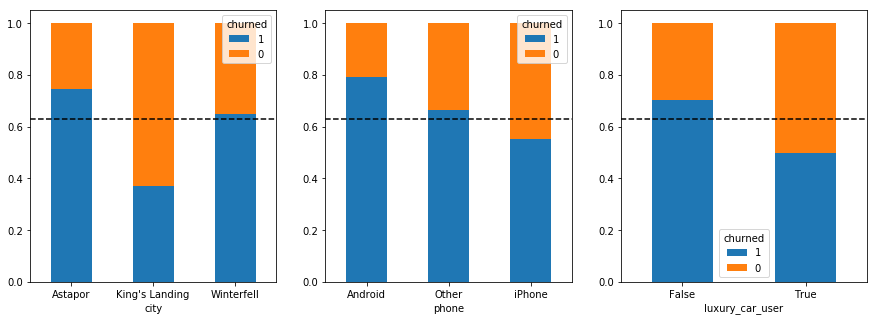

In [39]:
fig,ax = plt.subplots(1,3,figsize = (15,5))
for i in range(len(separate(clean_data)["categorical"])-1):
    temp = clean_data.groupby(separate(clean_data)["categorical"][i])["churned"].value_counts(normalize = True).unstack()
    temp = temp[[1,0]]
    temp.plot(kind = "bar",stacked = True,rot = 0,ax = ax[i])
    ax[i].hlines(0.63,-10,100,linestyle = "dashed") #dashed line if the average customers churn rate
plt.show()

### Insights
- City Astapor is experiencing a higher churn rate than average. Customers are unhappy in Astapor. King's Landing is managing the operations really well. A very low churn rate.
- Android users are unhappy / churning - There can be various issues here for example - UI for the Android app is too complex/ difficult for customers or customers experiencing other problems.
- Customers taking a luxury car in first 30 days churn less. We should promote usage of luxury cars.

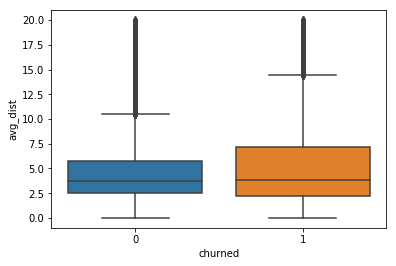

In [40]:
#Limiting the outliers to understand the relationship
sns.boxplot(y = "avg_dist",x= "churned",data = clean_data[clean_data.avg_dist < 20])

Non-churners seem to travel less distances in their first 30 days. This might be due to churning customers using the app to travel once/twice for large distances and never coming back again.

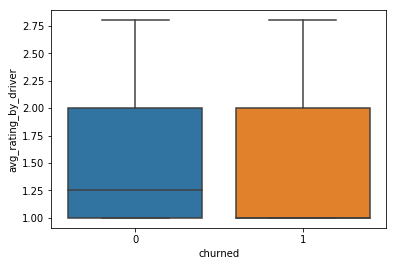

In [41]:
sns.boxplot(y = "avg_rating_by_driver",x= "churned",data = clean_data[clean_data.avg_rating_by_driver < 3])

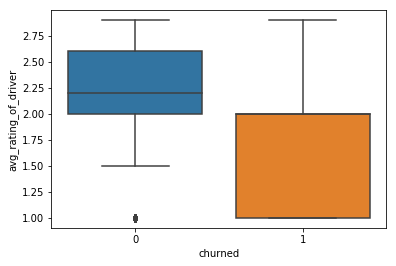

In [42]:
sns.boxplot(y = "avg_rating_of_driver",x= "churned",data = clean_data[clean_data.avg_rating_of_driver < 3])

Customers unhappy with drivers seem to churn more!

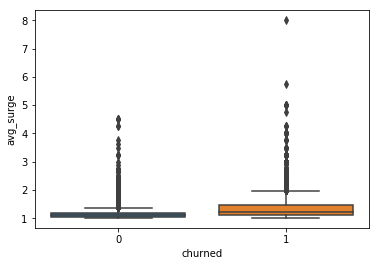

In [43]:
sns.boxplot(y = "avg_surge",x= "churned",data = clean_data[(clean_data.avg_surge > 1)])

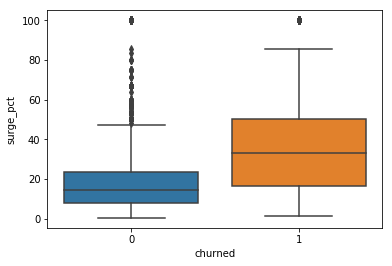

In [44]:
sns.boxplot(y = "surge_pct",x= "churned",data = clean_data[clean_data.surge_pct >0])

Customers who have had higher % of surge rides seem to churn more! 

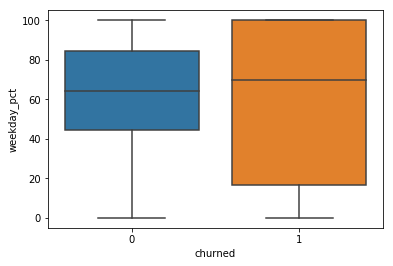

In [45]:
sns.boxplot(y = "weekday_pct",x= "churned",data = clean_data)

Nothing interesting here!

## Insights summarize
- Customers in Astapor churn more
- Android customers churn more
- Users who have used luxury cars churn less
- Customers giving poor ratings to drivers churn more
- Users experiencing higher surge charge are likely to churn more.

### Some relationships that we can explore based on the insights
- Are the customers in city Astapor experiencing higher surge or are they have poor experiences with drivers?
- Are Android users receiving surge/ Are people in certain cities experience higher surge?

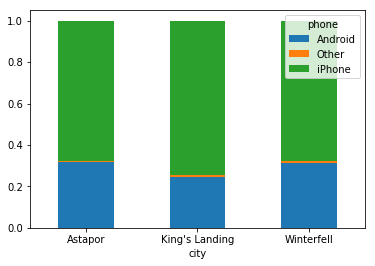

In [46]:
clean_data.groupby(["city"])["phone"].value_counts(normalize =True).unstack().plot(kind = "bar",stacked =True,rot = 0)

Astapor has higher % of Android customers, which is one of the reasons customers are churning. What is it about Android that makes them churn?

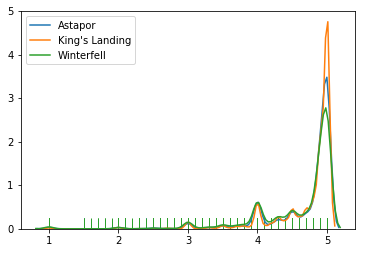

In [47]:
city_astapor = clean_data.loc[clean_data["city"] == "Astapor"]
city_king_landing = clean_data.loc[clean_data["city"] == "King's Landing"]
city_winterfell = clean_data.loc[clean_data["city"] == "Winterfell"]
sns.distplot(city_astapor[["avg_rating_of_driver"]],rug = True,hist= False,label = "Astapor")
sns.distplot(city_king_landing[["avg_rating_of_driver"]],rug = True,hist= False,label = "King's Landing")
sns.distplot(city_winterfell[["avg_rating_of_driver"]],rug = True,hist= False,label = "Winterfell")
plt.show()

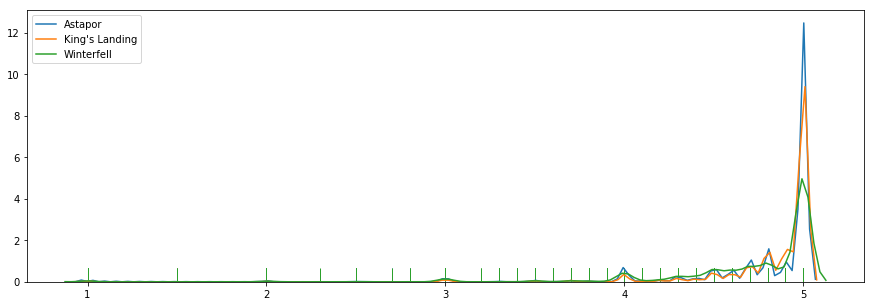

In [48]:
plt.figure(figsize = (15,5))
sns.distplot(city_astapor[["avg_rating_by_driver"]],rug = True,hist= False,label = "Astapor")
sns.distplot(city_king_landing[["avg_rating_by_driver"]],rug = True,hist= False,label = "King's Landing")
sns.distplot(city_winterfell[["avg_rating_by_driver"]],rug = True,hist= False,label = "Winterfell")
plt.show()

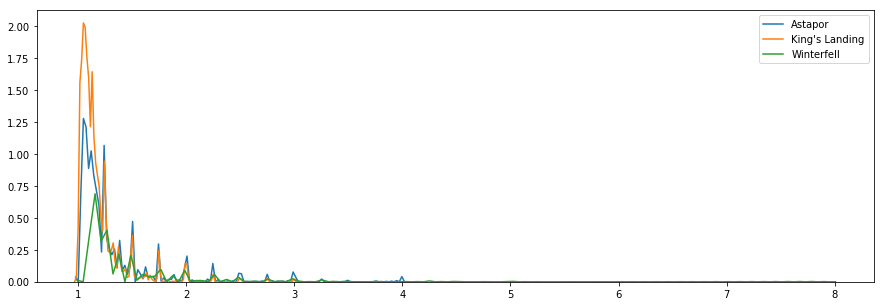

In [49]:
plt.figure(figsize = (15,5))
sns.distplot(city_astapor[["avg_surge"]],hist= False,label = "Astapor")
sns.distplot(city_king_landing[["avg_surge"]],hist= False,label = "King's Landing")
sns.distplot(city_winterfell[["avg_surge"]],hist= False,label = "Winterfell")
plt.show()

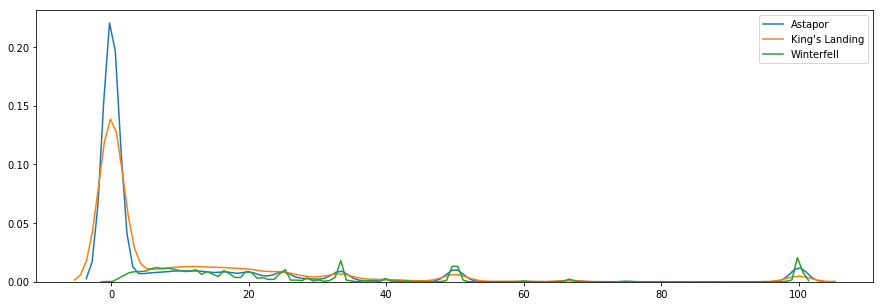

In [50]:
plt.figure(figsize = (15,5))
sns.distplot(city_astapor[["surge_pct"]],hist= False,label = "Astapor")
sns.distplot(city_king_landing[["surge_pct"]],hist= False,label = "King's Landing")
sns.distplot(city_winterfell[["surge_pct"]],hist= False,label = "Winterfell")
plt.show()

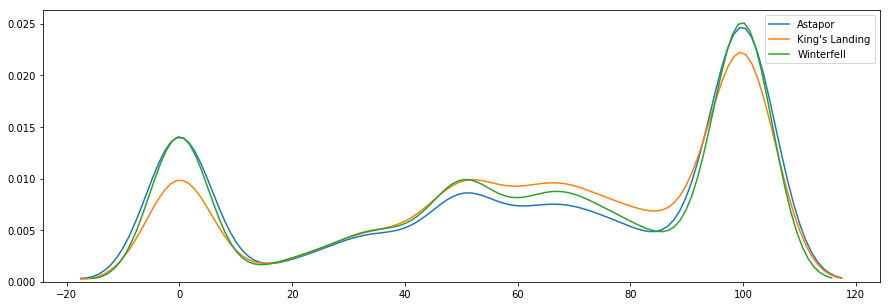

In [51]:
plt.figure(figsize = (15,5))
sns.distplot(city_astapor[["weekday_pct"]],hist= False,label = "Astapor")
sns.distplot(city_king_landing[["weekday_pct"]],hist= False,label = "King's Landing")
sns.distplot(city_winterfell[["weekday_pct"]],hist= False,label = "Winterfell")
plt.show()

Not much of a stark difference between the cities.

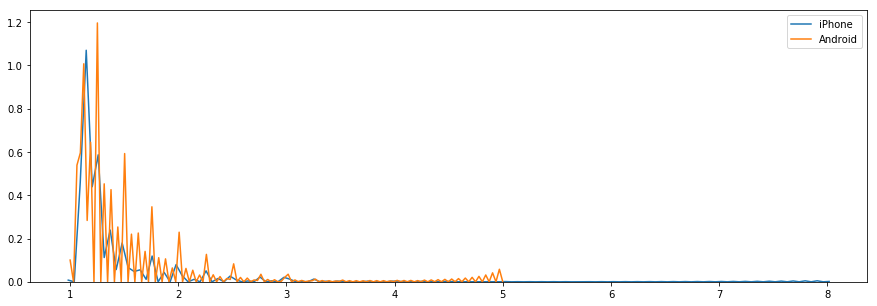

In [52]:
phone_iphone = clean_data.loc[clean_data["phone"] == "iPhone"]
phone_android = clean_data.loc[clean_data["phone"] == "Android"]
phone_other = clean_data.loc[clean_data["phone"] == "Other"]
plt.figure(figsize = (15,5))
sns.distplot(phone_iphone[["avg_surge"]],hist= False,label = "iPhone")
sns.distplot(phone_android[["avg_surge"]],hist= False,label = "Android")
#sns.distplot(phone_other[["avg_surge"]],hist= False,label = "Other")
plt.show()

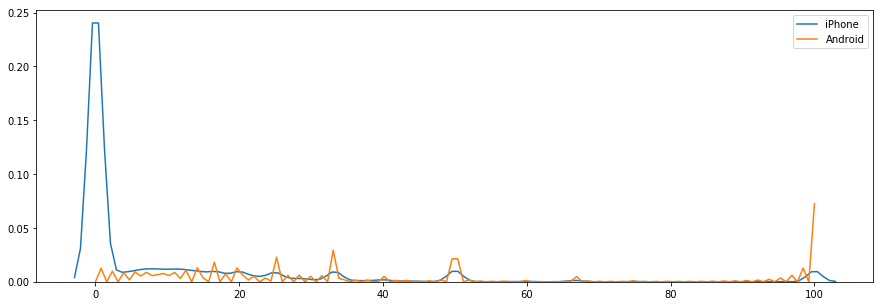

In [53]:
plt.figure(figsize = (15,5))
sns.distplot(phone_iphone[["surge_pct"]],hist= False,label = "iPhone")
sns.distplot(phone_android[["surge_pct"]],hist= False,label = "Android")
#sns.distplot(phone_other[["avg_surge"]],hist= False,label = "Other")
plt.show()

- Ok. So, Android users experience more surge pricing, and that makes them churn.

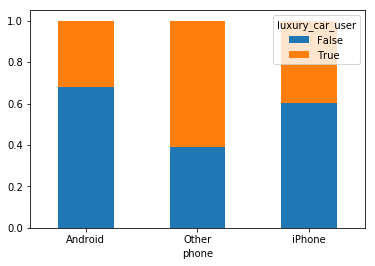

In [54]:
clean_data.groupby(["phone"])["luxury_car_user"].value_counts(normalize =True).unstack().plot(kind = "bar",stacked =True,rot = 0)

<Figure size 720x360 with 0 Axes>

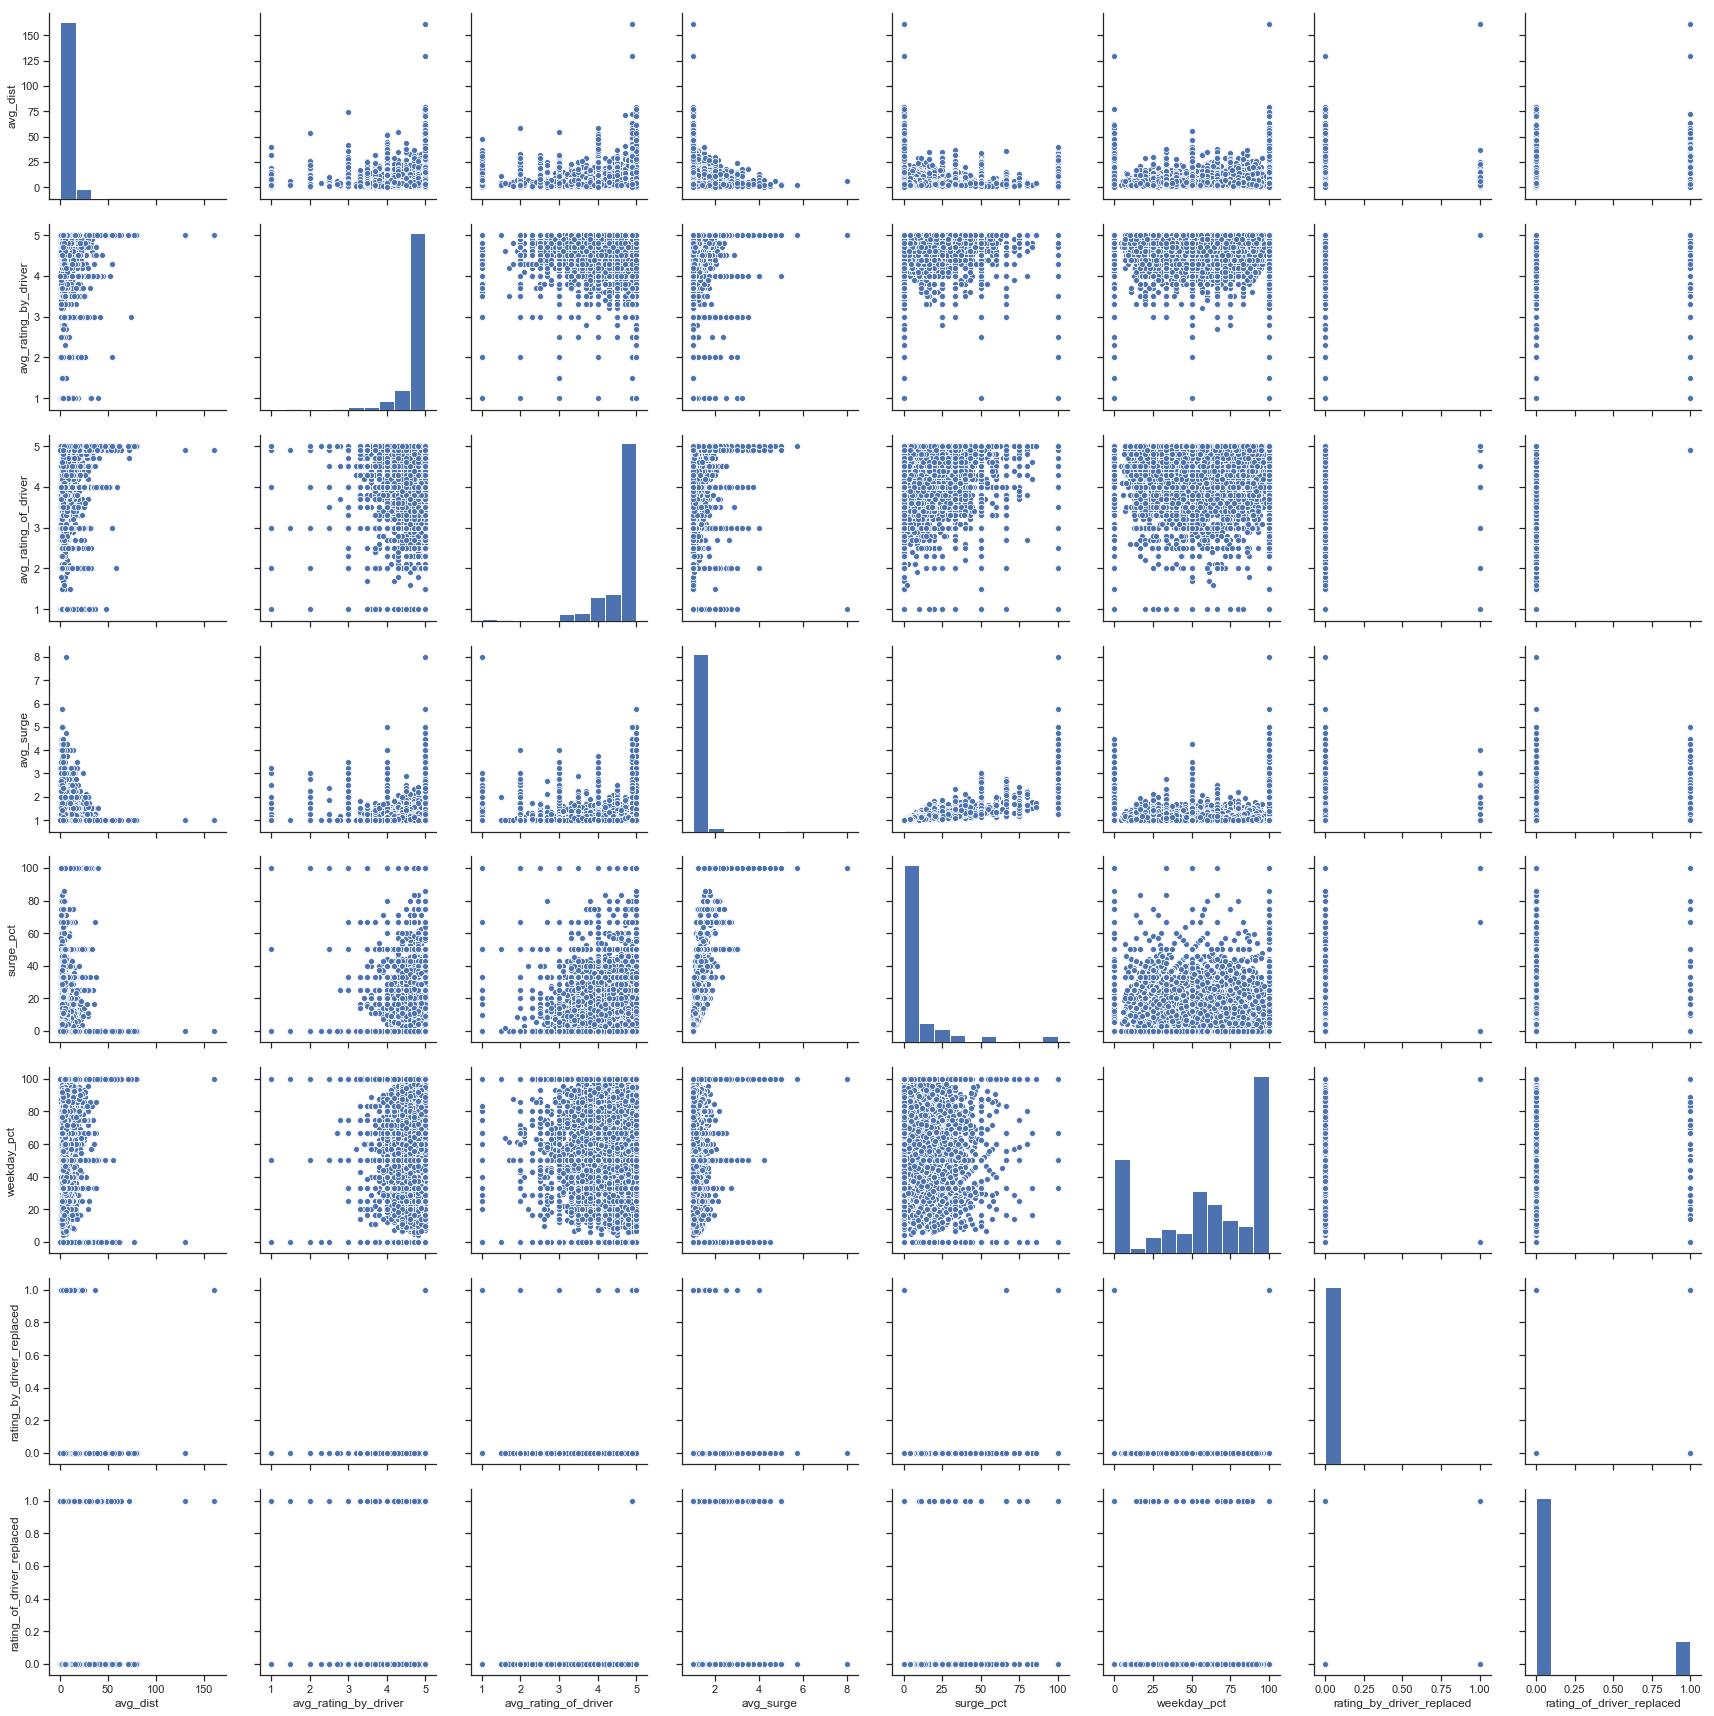

In [55]:
#Lets also look at scatterplots between our numerical variables
sns.set(style = "ticks",color_codes = True)
cols = separate(clean_data)["continuous"]
#cols.append("luxury_car_user")
plt.figure(figsize = (10,5))
sns.pairplot(clean_data[cols],height =3)
plt.show()

# Feature Engineering
#### - Few variables that makes sense based on insight
* We need a feature indicating Android users face surge pricing more number of times.
* We can also group the avg. ratings of customers - Ratings indicate whether a user is good/bad - we can create variables based on that.
* We can also group the weekday_pct to identify 3 groups of population - those who dont ride during week, those who ride only during week and others.

In [56]:
#Android users facing surge
clean_data["Android_user_facing_surge"] = 'No'
clean_data["Android_user_facing_surge"][(clean_data["phone"] == "Android") & (clean_data["surge_pct"] != 0)] = "Yes"

In [57]:
##Converting ratings into a categorical variable
clean_data["customer_behaviour"] = ''
clean_data.customer_behaviour[clean_data.avg_rating_by_driver >= 4] = "good"
clean_data.customer_behaviour[(clean_data.avg_rating_by_driver >= 3) & (clean_data.avg_rating_by_driver < 4)] = "okay"
clean_data.customer_behaviour[clean_data.avg_rating_by_driver < 3] = "bad"

In [58]:
clean_data["driver_behaviour"] = ''
clean_data.driver_behaviour[clean_data.avg_rating_of_driver >= 4] = "good"
clean_data.driver_behaviour[(clean_data.avg_rating_of_driver >= 3) & (clean_data.avg_rating_of_driver < 4)] = "okay"
clean_data.driver_behaviour[clean_data.avg_rating_of_driver < 3] = "bad"

In [59]:
#Weekday pct into groups
clean_data["ride_during_week"] = ''
clean_data.ride_during_week[clean_data.weekday_pct == 0] = "none"
clean_data.ride_during_week[clean_data.weekday_pct == 100] = "all"
clean_data.ride_during_week[(clean_data.weekday_pct > 0) & (clean_data.weekday_pct < 100)] = "some"

In [60]:
#sanity check
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 17 columns):
avg_dist                     49992 non-null float64
avg_rating_by_driver         49992 non-null float64
avg_rating_of_driver         49992 non-null float64
avg_surge                    49992 non-null float64
city                         49992 non-null object
phone                        49992 non-null object
signup_date                  49992 non-null datetime64[ns]
surge_pct                    49992 non-null float64
luxury_car_user              49992 non-null bool
weekday_pct                  49992 non-null float64
churned                      49992 non-null category
rating_by_driver_replaced    49992 non-null int64
rating_of_driver_replaced    49992 non-null int64
Android_user_facing_surge    49992 non-null object
customer_behaviour           49992 non-null object
driver_behaviour             49992 non-null object
ride_during_week             49992 non-null object
dtypes: bool

In [61]:
#changing rating_by_driver_replaced dtype to object
clean_data["rating_by_driver_replaced"] = clean_data["rating_by_driver_replaced"].astype("bool")
clean_data["rating_of_driver_replaced"] = clean_data["rating_of_driver_replaced"].astype("bool")

In [62]:
#Removing signup_date
clean_data.drop("signup_date",axis =1, inplace = True)
clean_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,luxury_car_user,weekday_pct,churned,rating_by_driver_replaced,rating_of_driver_replaced,Android_user_facing_surge,customer_behaviour,driver_behaviour,ride_during_week
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,15.4,True,46.2,0,False,False,No,good,good,some
1,8.26,5.0,5.0,1.00,Astapor,Android,0.0,False,50.0,1,False,False,No,good,good,some
2,0.77,5.0,4.3,1.00,Astapor,iPhone,0.0,False,100.0,1,False,False,No,good,good,all
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,20.0,True,80.0,0,False,False,No,good,good,some
4,3.13,4.9,4.4,1.19,Winterfell,Android,11.8,False,82.4,1,False,False,Yes,good,good,some


# Correlation

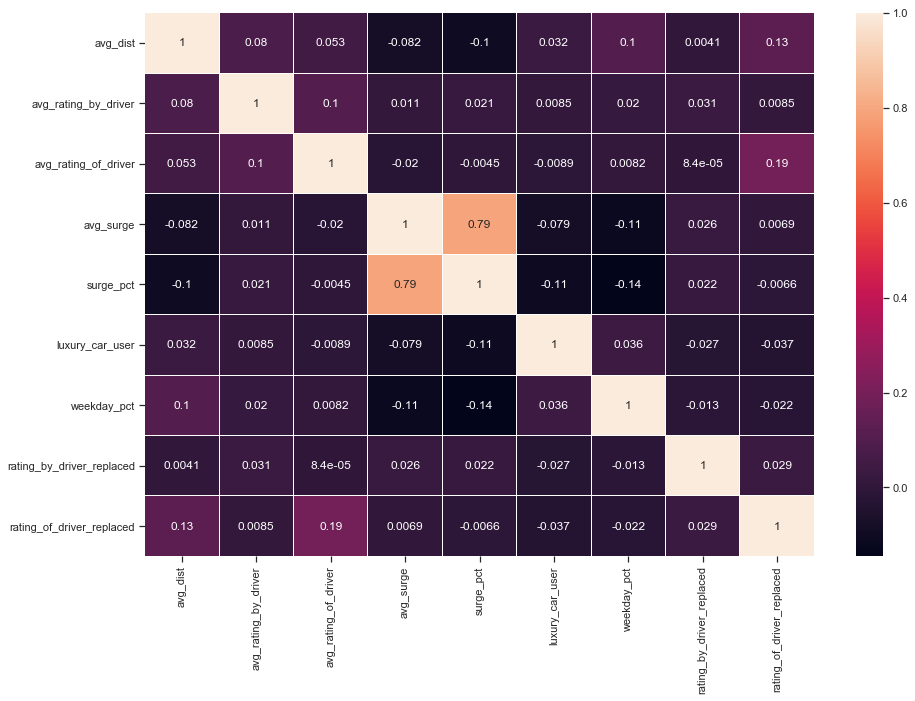

In [63]:
plt.figure(figsize = (15,10))
sns.heatmap(clean_data.corr(),annot = True,linewidth = 0.2)
plt.show()

### As seen before, avg_surge and surge_pct are highly correlated! There is little correlation among other variables, but nothing significant. I am going to remove avg_surge as surge_pct gives a better indication of the surge pricing experienced by the customer.

In [64]:
clean_data.drop("avg_surge",axis = 1,inplace = True)

# Data Preparation

### Dummy variables

In [65]:
#Converting categorical variables into dummy variables
clean_data = pd.get_dummies(clean_data, drop_first = True,columns = ["city","phone","Android_user_facing_surge","customer_behaviour","driver_behaviour","ride_during_week"])

In [66]:
#sanity check
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 20 columns):
avg_dist                         49992 non-null float64
avg_rating_by_driver             49992 non-null float64
avg_rating_of_driver             49992 non-null float64
surge_pct                        49992 non-null float64
luxury_car_user                  49992 non-null bool
weekday_pct                      49992 non-null float64
churned                          49992 non-null category
rating_by_driver_replaced        49992 non-null bool
rating_of_driver_replaced        49992 non-null bool
city_King's Landing              49992 non-null uint8
city_Winterfell                  49992 non-null uint8
phone_Other                      49992 non-null uint8
phone_iPhone                     49992 non-null uint8
Android_user_facing_surge_Yes    49992 non-null uint8
customer_behaviour_good          49992 non-null uint8
customer_behaviour_okay          49992 non-null uint8
driver_behaviour_

In [67]:
#Before scaling, lets divide our data into training and testing splits
features = [i for i in clean_data.columns if i != "churned"]
target = ["churned"]
X_train, X_test, y_train, y_test = train_test_split(clean_data[features], clean_data[target], test_size=0.2,random_state = 1)

### Scaling the features

In [68]:
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

## PCA Analysis

In [98]:
cor_mat1 = np.corrcoef(X_train.T)
eig_vals, eig_vecs = np.linalg.eig(cor_mat1)
# Looking at sorted eigenvalues
rounded_eigs = [np.around(i,5) for i in eig_vals]
sorted_eigs  = sorted(rounded_eigs, reverse = True)
print('Eigenvalues in descending order:')
for i in sorted_eigs:
    print(i)

Eigenvalues in descending order:
2.70131
2.4013
1.95597
1.6418
1.48171
1.34875
1.09704
0.9961
0.93682
0.89129
0.84557
0.70033
0.51257
0.48605
0.44056
0.39406
0.06512
0.05433
0.04932


Most of the variance in the data cannot be explained only by a few principal components. Here, variance is spread across all the components. PCA isn't too helpful.

# Evaluation Metrics - Model Comparison
- Since, the target is to identify churning customers correctly, we need to focus more on getting True Positive correct (High TPR). We can let off False Positive errors (Customers we predicted will churn, but do not!) as they are not that important.
- Also, we need to lower the False Negative error (Customers we predicted will not churn, but they did churn!). In this case, we might lose these customers due to the error.

#### So, our main target would be to - MAXIMIZE TRUE POSITIVES and MINIMIZE FALSE NEGATIVE ERRORS!

#### Metrics we'll look at:
- ROC-AUC curve
- Confusion Matrix

## MODEL COMPARISON METRICS

In [118]:
def cross_validation(model,xtrain,ytrain, scoretype, folds):
    scores = cross_val_score(estimator = model,X= xtrain, y = ytrain,scoring = scoretype,cv = folds)
    print("%s: %0.3f (+/- %0.2f)" % ("roc-auc",scores.mean(),scores.std()))
    
           
def roc_curve(X_test,y_test,model,model_name):
    from sklearn import metrics
    roc_auc = metrics.roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    fpr,tpr,threshold = metrics.roc_curve(y_test,model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr,tpr,label = "Model:" + model_name +(" (AUC) = %0.2f")%roc_auc)
    plt.plot([0,1],[0,1],"r--")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend(loc = "lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.show()

## MODELLING

### Logistic Regression

In [103]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression()

roc-auc: 0.816 (+/- 0.00)


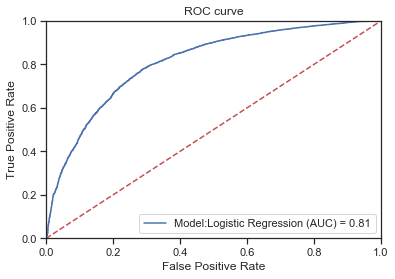

In [119]:
cross_validation(log_model,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,log_model,"Logistic Regression")

### Decision Tree

In [120]:
dtree = DecisionTreeClassifier(random_state = 42)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

roc-auc: 0.673 (+/- 0.01)


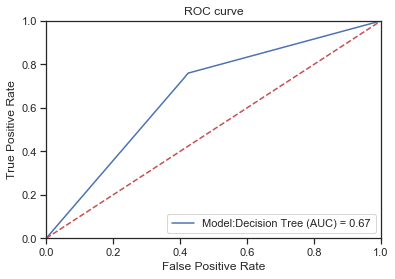

In [121]:
cross_validation(dtree,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,dtree,"Decision Tree")

### Random Forest

In [124]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

roc-auc: 0.794 (+/- 0.00)


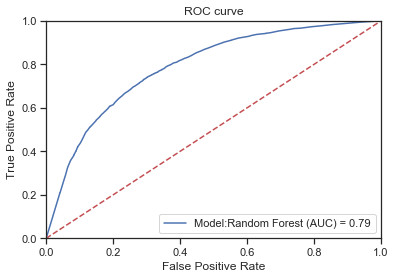

In [126]:
cross_validation(rf,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,rf,"Random Forest")

### Gradient Boosting

In [147]:
gbm = ensemble.GradientBoostingClassifier(random_state = 30)
gbm.fit(X_train,y_train)

GradientBoostingClassifier(random_state=30)

roc-auc: 0.842 (+/- 0.00)


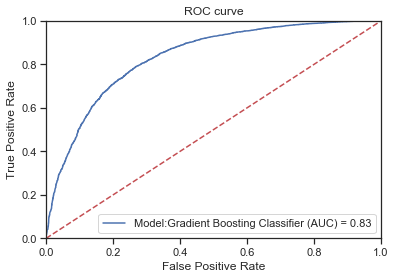

In [148]:
cross_validation(gbm,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,gbm,"Gradient Boosting Classifier")

### AdaBoost

In [135]:
ab = ensemble.AdaBoostClassifier(random_state = 30)
ab.fit(X_train,y_train)

AdaBoostClassifier(random_state=30)

roc-auc: 0.840 (+/- 0.00)


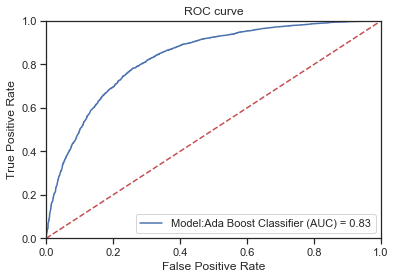

In [136]:
cross_validation(ab,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,ab,"Ada Boost Classifier")

We have tried 4 different base models, and all the boosting models have done exceedingly well. Lets short-list all the boosting models, and hyper-tune their parameters and see whether we can improve the performance even further.

## Model Optimization: Hyper-tuning parameters
There are two ways to hyper tune parameters:
    1. Grid Search (takes too much time - will try every combination of parameters provided)
    2. Random Search (takes less time - will try random combinations)

### Model 1: Gradient Boosting 
There are a lot of hyper-parameters to tune. Lets first tune Gradient Boosting Classifier.
The key parameters we will tune here are:
    1. number of estimators
    2. max_Depth
    3. Learning rate

There are other tree-related paramters such as min_samples_split; min_samples_leaf; sub-sample; max_features that we can tune. But we will not do that here.

We will tune each of these hyper-paramters in stages.

#### Grid-Search

In [152]:
#Tuning learning-rate and number of trees - with change in learning rate, we are adjusting number of estimators as well
param_grid = { 'learning_rate' : [0.15,0.1,0.05,0.01,0.005,0.001],
              'n_estimators' :[100,250,500,750,1000,1250,1500,1750],
              }
grid = RandomizedSearchCV(estimator = ensemble.GradientBoostingClassifier(),param_distributions = param_grid,n_jobs =-1,scoring = "roc_auc")
grid.fit(X_train,y_train)

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.15, 0.1, 0.05, 0.01,
                                                          0.005, 0.001],
                                        'n_estimators': [100, 250, 500, 750,
                                                         1000, 1250, 1500,
                                                         1750]},
                   scoring='roc_auc')

In [153]:
print(grid.best_params_, grid.best_score_)

{'n_estimators': 750, 'learning_rate': 0.05} 0.8441421287179353


Now, lets tune tree-specific hyper-parameters. We will only tune max_depth here.

In [154]:
#Tuning max_depth
param_grid = { 'max_depth' : list(np.linspace(0,10,6)),
              }
grid = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 750 ),param_grid = param_grid,n_jobs =-1,cv =5,scoring = "roc_auc")
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  n_estimators=750),
             n_jobs=-1,
             param_grid={'max_depth': [0.0, 2.0, 4.0, 6.0, 8.0, 10.0]},
             scoring='roc_auc')

In [155]:
print(grid.best_params_, grid.best_score_)

{'max_depth': 2.0} 0.8435381028397151


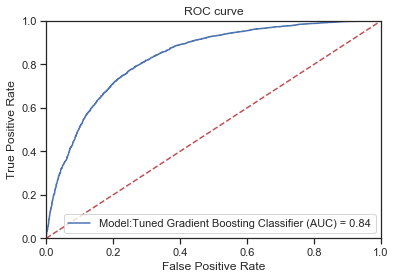

In [157]:
#Tuned Classifier
gbm_tuned = ensemble.GradientBoostingClassifier(learning_rate =0.05 ,n_estimators =750 ,random_state = 42, max_depth =2)
gbm_tuned.fit(X_train,y_train)
roc_curve(X_test,y_test,gbm_tuned,"Tuned Gradient Boosting Classifier")

### Model 2: AdaBoost

In [158]:
#Tuning learning-rate and number of trees - with change in learning rate, we are adjusting number of estimators as well
param_grid = { 'learning_rate' : [0.15,0.1,0.05,0.01,0.005,0.001],
              'n_estimators' :[100,250,500,750,1000,1250,1500,1750],
              }
grid = RandomizedSearchCV(estimator = ensemble.AdaBoostClassifier(),param_distributions = param_grid,n_jobs =-1,cv =5,scoring = "roc_auc")
grid.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.15, 0.1, 0.05, 0.01,
                                                          0.005, 0.001],
                                        'n_estimators': [100, 250, 500, 750,
                                                         1000, 1250, 1500,
                                                         1750]},
                   scoring='roc_auc')

In [159]:
print(grid.best_params_, grid.best_score_)

{'n_estimators': 1250, 'learning_rate': 0.15} 0.8416870775329286


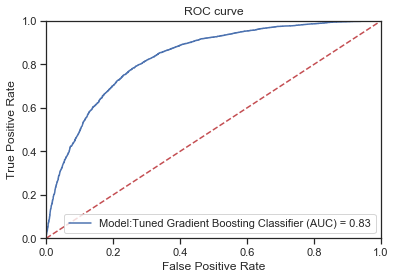

In [160]:
#Tuned Classifier
ab_tuned = ensemble.AdaBoostClassifier(learning_rate = 0.15 ,n_estimators = 1250 ,random_state = 42)
ab_tuned.fit(X_train,y_train)
roc_curve(X_test,y_test,ab_tuned,"Tuned Gradient Boosting Classifier")

Our tuned Gradient Boosted Classifer has performed the best, therefore, I am choosing it as my final model.

# Final Predicted Probabilities

In [164]:
predictions = gbm_tuned.predict_proba(X_test)[:,1]
predictions

array([0.76148851, 0.05641078, 0.94424031, ..., 0.93586545, 0.14400444,
       0.92145139])

# Choosing an Optimal Threshold
Now, we have our final model in the tuned Gradient Boosting with an ROC-AUC equal to 0.84.

To get the best possible predictions, we need to choose an optimal threshold.

- Since, it is a binary classification problem, we have 4 possible outcomes (TP, TN, FP and FN), and in a business, all 4 have a cost associated to it. Since, the threshold affects all the 4 outcomes, I need to assign a cost to each.


#### Assigning Costs

What are the costs for each outcome? It usually varies for each business setting. Lets make some assumptions here.
- Firstly, the cost of True Negative(TN) would be equal to USD 0. This outcome essentially means, that we have correctly identifed customers who are NOT going to churn, and therefore, we dont need to do anything.
- False Negatives are the biggest concern for us. Those are the customers that we incorrectly predicted as not going to churn. We lose these customers, as we will not be taking any action here, and therefore, we will have to pay all the costs of acquiring a replacement customer (including revenue, advertising costs, administrative costs, POS costs, etc.) A quick Google search revealed, such costs vary for every company, but it takes roughly around \$70 for ride-share companies to acquire a new customer.
- Finally, for customers that we correctly identified as churning, lets assume the company would give a retention incentive in the form of discounts which could cost company around USD 20. 
If my Uber gave me such a discount, thats around 2 rides for me and I'd certainly think before leaving. This would be the cost for both True Positive and False Positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the USD 20 concession. We probably could have spent that \$20 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

Instead of optimizing based on number of customers, we'll select the final model based on minimizing the cost function.

The cost function:

70 * FN(C) + 0 * TN(C) + 20 * FP(C) + 20 * TP(C)

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP. We need to find the cutoff, C, where the result of the expression is smallest.

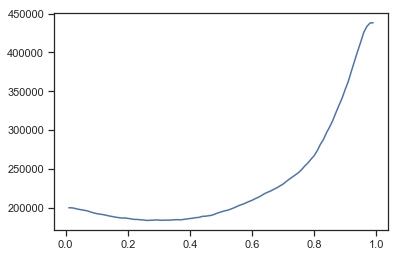

Cost is minimized near a cutoff of: 0.26 for a cost of: 183720


In [271]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 20], [70, 20]]) * 
                              metrics.confusion_matrix(y_test,np.where(predictions > c, 1, 0))                              )
                       )
                )

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

- This chart shows that picking a low threshold works in the best interest as 63% of customers are churning (previously observed!). If we give all the customers a retention incentive, it would cost us around USD 200,000. However, with this model and the threshold of 0.26, the overall cost can be minimized at USD 183,720. The graph also shows, how not taking any action would be disastrous as the costs are sky-rocketing at USD 438,130.

In [272]:
final_predictions = np.where(predictions > cutoffs[np.argmin(costs)],1,0)

In [273]:
metrics.confusion_matrix(y_test,final_predictions)

array([[1388, 2352],
       [ 230, 6029]], dtype=int64)

In [274]:
print("Overall accuracy on the model:",metrics.accuracy_score(y_test,final_predictions))

Overall accuracy on the model: 0.7417741774177418


# Factors driving customers to churn

In [287]:
pd.DataFrame({'features': features, 'importance': gbm_tuned.feature_importances_}).sort_values('importance',ascending = False)

,features,importance
18,ride_during_week_some,0.335231
8,city_King's Landing,0.168740
1,avg_rating_by_driver,0.149428
3,surge_pct,0.119991
11,phone_iPhone,0.090022
4,luxury_car_user,0.069304
5,weekday_pct,0.021665
0,avg_dist,0.020130
9,city_Winterfell,0.015161
2,avg_rating_of_driver,0.009357


# Final Take:

Not taking any action on the customers, would cost the company a lot of money- around USD 438,000. With usage of the model and analysis, company can reach out to the churning customers with incentives and minimize the cost to USD 183,000.

- Also, Android users are expriencing a higher surge charge compared to iPhone users - and that is causing them to churn.
- Customers in Astapor are churning more and King's Landing are less likely to churn.
- Also, company should promote usage of luxury_car in the first 30 days as it is promoting retention.
- Finally, riding during the week and ratings provided by the driver are important factors to look for to identify churning customers.



#### - Extensions
- Some customers who receive retention incentives will still churn. Including a probability of churning despite receiving an incentive in our cost function would provide a better ROI on our retention programs.
- Actual training data and monetary cost assignments could be more complex.
- Multiple models for each type of churn could be needed.
